# Multi-Tissue Constrained Spherical Deconvolution

Multi-Tissue CSD (MT-CSD), or what *Jeurissen et al. (2014)* refers to as Multi-Shell Multi-Tissue CSD (MSMT-CSD), is in extension of regular CSD algorithm. In MT-CSD, Aside from the standard white matter convolution kernel, also a CSF and grey matter kernel are estimated from the data, and fitted simultaneously fitted for better FOD estimation.

$$
\begin{equation}
 E_{\textrm{MT-CSD}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{CSF}}+ \underbrace{f_{\textrm{GM}}\overbrace{E_{\textrm{iso}}(\cdot)}^{\textrm{Isotropic Response}}}_{\textrm{Grey Matter}} + \underbrace{f_r\left[\overbrace{\operatorname{FOD}(\operatorname{SH}|l_{\textrm{max}})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{E_{\textrm{WM}}(\cdot)}^{\textrm{Anisotropic Response}}\right]}_{\textrm{White Matter}}
\end{equation}
$$

The original algorithm uses registered T1 image segmentations of white/grey matter and CSF to obtain these separate kernels, but this has shown to be a difficult and expensive process. Instead, we implement unsupervised approach by *Dhollander et al. (2016)* that directly estimates the three tissue kernels from the dMRI data itself.

Once the kernels are estimated, they can be used exactly as any other Dmipy compartment model. This means they can be used in any modeling framework together with other models as usual.

As you will see, MT-CSD results in very well-defined FOD profiles and hardly any noisy voxels around CSF or Grey matter areas.

## Using Dmipy to set up the MT-CSD Model¶

Setting up the MT-CSD model in Dmipy is very easy. The only thing that needs to be done is to generate the WM/GM/CSF tissue response models from the data using the dhollander16 algorithm. Then, the rest of the modeling can be done as usual.

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


### Unsupervised Three-Tissue Response Function Estimation

The dhollander16 algorithm, which heuristically estimates the white/grey matter and CSF response functions from the dMRI data (instead of using a T1 segmentation), can be directly called with the acquisition scheme and the data. The generated tissue response models are always generated in the same order.

To estimate the white matter response function, we can modularly choose any available algorithm, currently:
- the classic 'tournier07' algorithm based on FA only,
- the iterative 'tournier13' algorithm, which refines the response function based on the ratio between the first and secondarly peak of the FODs (currently used in MRtrix).

In the following commands we generate the three response functions, and change some of the default dhollander16 parameters to account for that we're only fitting a single slice instead of a whole brain:

In [2]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
S0_tissue_responses, tissue_response_models, selection_map = three_tissue_response_dhollander16(
    scheme_hcp, data_hcp, wm_algorithm='tournier07',
    wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
TR2_wm, TR1_gm, TR1_csf = tissue_response_models
S0_wm, S0_gm, S0_csf = S0_tissue_responses

/home/rutger/anaconda2/lib/python2.7/site-packages/dmipy-1.0.3-py2.7.egg/dmipy/tissue_response/three_tissue_response.py:226: RuntimeWarning: The signal decay metric reached unrealistically high or negative values and was clipped to [0, 10]


In [3]:
E_wm = TR2_wm(scheme_hcp, mu=[0., 0.])

In [4]:
from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.distributions import distribute_models
from dmipy.core import modeling_framework
stick = cylinder_models.C1Stick()
zep = gaussian_models.G2Zeppelin()
mck_dist = distribute_models.SD1WatsonDistributed([stick, zep])
mck_dist.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
mck_dist.set_tortuous_parameter('G2Zeppelin_1_lambda_perp', 'G2Zeppelin_1_lambda_par', 'partial_volume_0')
mck = modeling_framework.MultiCompartmentModel([mck_dist])
mck.set_fixed_parameter('SD1WatsonDistributed_1_SD1Watson_1_mu', [0., 0.])
mck.set_parameter_optimization_bounds('SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par', [0., 4e-9])

In [5]:
mt_kernel_fit_init = mck.fit(scheme_hcp, E_wm)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 3.31311798096 seconds
Fitting of 1 voxels complete in 3.9009001255 seconds.
Average of 3.9009001255 seconds per voxel.


In [6]:
mt_kernel_fit_init.fitted_parameters

{'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': array([3.0245025e-09]),
 'SD1WatsonDistributed_1_SD1Watson_1_odi': array([0.15979274]),
 'SD1WatsonDistributed_1_partial_volume_0': array([0.94384072])}

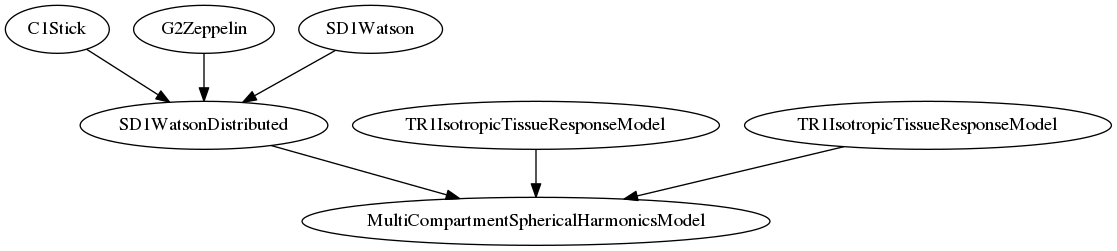

In [7]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
from IPython.display import Image

mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(
    models=[mck_dist, TR1_gm, TR1_csf],
    S0_tissue_responses=S0_tissue_responses)
mt_csd_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

In [18]:
import numpy as np
fit_args = {'acquisition_scheme': scheme_hcp,
            'data': data_hcp[55:57, :, 68:70],
            'mask': data_hcp[55:57, :, 68:70, 0]>0}
fit_args = {'acquisition_scheme': scheme_hcp,
            'data': data_hcp[70:85, :, 72:82],
            'mask': data_hcp[70:85, :, 72:82, 0]>0}
mt_csd_fits = []
mt_kernel_fits = []
for it in range(5):
    mt_csd_mod = MultiCompartmentSphericalHarmonicsModel(models=[mck_dist, TR1_gm, TR1_csf])
    if it == 0:
        mt_csd_mod.set_fixed_parameter('SD1WatsonDistributed_1_partial_volume_0',
                                       mt_kernel_fit_init.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0'])
        mt_csd_mod.set_fixed_parameter('SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
                                       mt_kernel_fit_init.fitted_parameters['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'])
        mt_csd_mod.set_fixed_parameter('SD1WatsonDistributed_1_SD1Watson_1_odi',
                                       mt_kernel_fit_init.fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_odi'])
    else:
        mt_csd_mod.set_fixed_parameter('SD1WatsonDistributed_1_partial_volume_0',
                                       mt_kernel_fit.fitted_parameters['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0'])
        mt_csd_mod.set_fixed_parameter('SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
                                       mt_kernel_fit.fitted_parameters['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'])
        mt_csd_mod.set_fixed_parameter('SD1WatsonDistributed_1_SD1Watson_1_odi',
                                       mt_kernel_fit.fitted_parameters['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi'])
    mt_csd_fit = mt_csd_mod.fit(**fit_args)
    print(np.mean(mt_csd_fit.mean_squared_error(fit_args['data'])))
    mt_csd_fits.append(mt_csd_fit)
    
    mt_csd_kernel_mod = modeling_framework.MultiCompartmentModel(
        [distribute_models.SD3SphericalHarmonicsDistributed([mck_dist], sh_order=8), TR1_gm, TR1_csf])
    mt_csd_kernel_mod.set_fixed_parameter(
        'SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff',
        mt_csd_fit.fitted_parameters['sh_coeff'])
    mt_csd_kernel_mod.set_initial_guess_parameter(
        'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
        mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'])
    mt_csd_kernel_mod.set_initial_guess_parameter(
        'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi',
        mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_odi'])
    mt_csd_kernel_mod.set_initial_guess_parameter(
        'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0',
        mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0'])
    for i in range(3):
        mt_csd_kernel_mod.set_fixed_parameter(
        'partial_volume_{}'.format(i),
        mt_csd_fit.fitted_parameters['partial_volume_{}'.format(i)])
    mt_csd_kernel_mod.set_parameter_optimization_bounds(
        'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par', [0., 4e-9])
    mt_kernel_fit = mt_csd_kernel_mod.fit(use_parallel_processing=True, **fit_args)
    print(np.mean(mt_kernel_fit.mean_squared_error(fit_args['data'])))
    mt_kernel_fits.append(mt_kernel_fit)

Setup CVXPY FOD optimizer in 0.00592303276062 seconds
Using parallel processing with 8 workers.
Fitting of 150 voxels complete in 15.2275090218 seconds.
Average of 0.101516726812 seconds per voxel.
0.0703983179033109
All model parameters set or have initial guess.
All model parameters set or have initial guess.
Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000499963760376 seconds
Fitting of 150 voxels complete in 268.620037079 seconds.
Average of 1.79080024719 seconds per voxel.
0.003069374123931799
Setup CVXPY FOD optimizer in 0.0240209102631 seconds
Using parallel processing with 8 workers.
Fitting of 150 voxels complete in 14.6218450069 seconds.
Average of 0.097478966713 seconds per voxel.
0.06843916657801387
All model parameters set or have initial guess.
All model parameters set or have initial guess.
Using parallel processing with 8 workers.
Cannot estimate signal grid with voxel-dependent x0_

In [36]:
np.mean(mt_kernel_fit.mean_squared_error(fit_args['data']))

0.002934144859039165

In [37]:
np.mean(mt_csd_fit.mean_squared_error(fit_args['data']))

0.06855775663023204

(array([ 3544., 16339., 12902.,  6480.,  1865.,   198.,   414.,   360.,
          468.,   630.]),
 array([0.03310895, 0.22979805, 0.42648716, 0.62317626, 0.81986537,
        1.01655447, 1.21324358, 1.40993268, 1.60662179, 1.80331089,
        2.        ]),
 <a list of 10 Patch objects>)

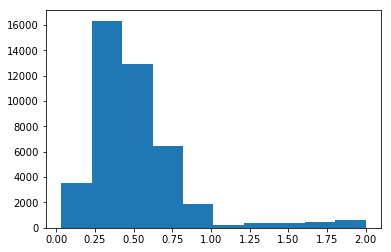

In [42]:
plt.hist(mt_csd_fit.predict(S0=1.).ravel())

In [40]:
np.where(mt_csd_fit.predict(S0=1.) == mt_csd_fit.predict(S0=1.).max())

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([  0,  16,  32,  48,  64,  80,  95, 112, 128, 144, 160, 176, 191,
        208, 224, 240, 256, 272]))

In [9]:
mt_csd_fit.predict() - fit_args['data']

array([[[[ -35.862968  ,  167.98770566, -272.63183298, ...,
           -24.00305611,   79.94160704,  256.77992002],
         [ -40.60581766, -263.79340271, -277.0988763 , ...,
           -30.32453597,  243.46540655,  138.42418221]]],


       [[[ 224.31248955,  395.55323761,  202.35772146, ...,
           180.99993622, -345.01142188,  573.95206788],
         [ -32.45521214,  153.18532393, -397.94431094, ...,
           109.01057219,   70.43449382,  -47.87445644]]]])

In [10]:
predicted_mtcsd = mt_csd_fit.predict(S0=1.)

In [58]:
mt_csd_kernel_mod = modeling_framework.MultiCompartmentModel(
        [distribute_models.SD3SphericalHarmonicsDistributed([mck_dist], sh_order=8), TR1_gm, TR1_csf])

In [59]:
params = {}
params['SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff'] =\
    mt_csd_fit.fitted_parameters['sh_coeff']
params['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par']=\
        mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par']
params['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi']=\
        mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_odi']
params['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0']=\
        mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0']
for i in range(3):
        params['partial_volume_{}'.format(i)]=\
        mt_csd_fit.fitted_parameters['partial_volume_{}'.format(i)]

In [36]:
predict_kernel = mt_csd_kernel_mod.simulate_signal(scheme_hcp, params)

In [48]:
import numpy as np
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.distributions import distribute_models
from dmipy.core import modeling_framework


mcsh = MultiCompartmentSphericalHarmonicsModel(models=[mck_dist], sh_order=8)
mc = modeling_framework.MultiCompartmentModel(
        [distribute_models.SD3SphericalHarmonicsDistributed([mck_dist], sh_order=8)])

lambda_par=0.
odi = .02
sh_coeff = np.ones(45)
sh_coeff[0] =  1 / (2 * np.sqrt(np.pi))
pv0 = .3

params_mcsh = {
 'SD1WatsonDistributed_1_partial_volume_0': pv0,
 'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': lambda_par,
 'SD1WatsonDistributed_1_SD1Watson_1_odi': odi,
 'sh_coeff': sh_coeff
}

params_mc = {
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0': pv0,
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': lambda_par,
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi': odi,
 'SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff': sh_coeff
}

E_mcsh = mcsh.simulate_signal(scheme_hcp, params_mcsh)
E_mc = mc.simulate_signal(scheme_hcp, params_mc)

np.testing.assert_array_almost_equal(E_mcsh, E_mc)

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [37]:
mcsh_mat = mcsh._construct_convolution_kernel(scheme_hcp,**params_mcsh)

In [38]:
mod_mc = distribute_models.SD3SphericalHarmonicsDistributed([mck_dist], sh_order=8)

params_mc = {
 'SD1WatsonDistributed_1_partial_volume_0': pv0,
 'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': lambda_par,
 'SD1WatsonDistributed_1_SD1Watson_1_odi': odi,
 'SD3SphericalHarmonics_1_sh_coeff': sh_coeff
}
mod_mc.parameter_names

['SD3SphericalHarmonics_1_sh_coeff',
 'SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
 'SD1WatsonDistributed_1_SD1Watson_1_odi']

In [39]:
mc_mat = mod_mc.convolution_kernel_matrix(scheme_hcp, lmax=8, **params_mc)

In [43]:
(mc_mat - mcsh_mat).min()

-6.521731325578287e-16

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
mcsh_mat.shape

(288, 45)

In [30]:
mc_mat.shape

(288, 45)

In [ ]:
plt.

In [40]:
mcsh.parameter_names

['SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
 'SD1WatsonDistributed_1_SD1Watson_1_odi',
 'sh_coeff']

In [19]:
errors = []
odis = []
for fit in mt_kernel_fits:
    errors.append(fit.mean_squared_error(fit_args['data']).squeeze())
    odis.append(fit.fitted_parameters['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi'])

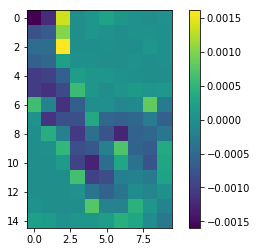

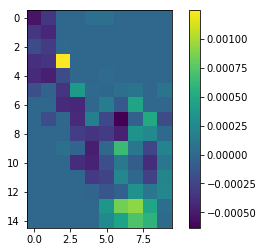

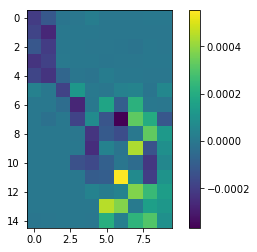

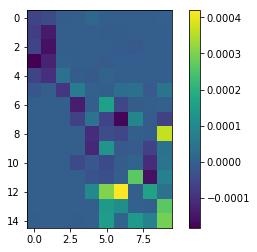

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(len(errors) - 1):
    plt.figure()
    plt.imshow(errors[i+1] - errors[i])
    plt.colorbar()

In [27]:
mt_kernel_fit.fitted_parameters.keys()

['partial_volume_1',
 'partial_volume_0',
 'partial_volume_2',
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi',
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0',
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
 'SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff']

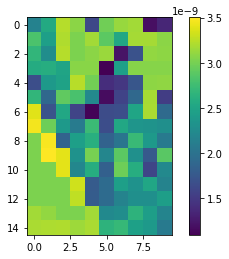

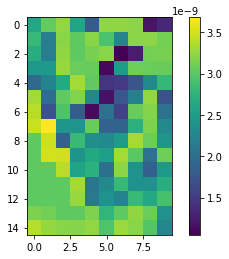

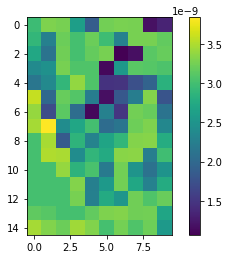

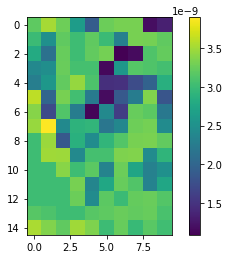

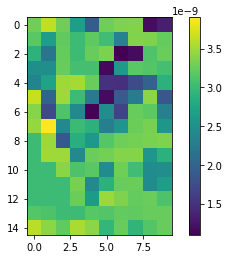

In [34]:
param_name = 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'
for fit in mt_kernel_fits:
    plt.figure()
    _param = fit.fitted_parameters[param_name]
    plt.imshow(_param.squeeze())
    plt.colorbar()

In [ ]:
for i in range(len(errors) - 1):
    plt.figure()
    plt.imshow(errors[i+1] - errors[i])
    plt.colorbar()

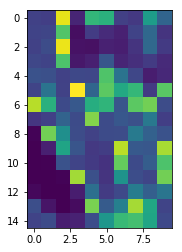

In [92]:
plt.imshow(errors[].squeeze())

In [73]:
for fit in mt_csd_fits:
    print(fit.mean_squared_error(data_hcp[55:56, :, 68:69]))

[[[0.00390161]]]
[[[0.00303831]]]
[[[0.00283614]]]
[[[0.00282135]]]
[[[0.00304117]]]
[[[0.00467596]]]
[[[0.01127111]]]
[[[0.0154059]]]
[[[0.0154059]]]
[[[0.0154059]]]


In [41]:
mt_kernel_fit.fitted_parameters['SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0']

array([[[0.01]]])

In [42]:
mt_csd_mod.parameter_cardinality

OrderedDict([('SD1WatsonDistributed_1_partial_volume_0', 1),
             ('SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par', 1),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1),
             ('sh_coeff', 45)])

In [39]:
mt_kernel_fit.fitted_parameters

{'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': array([[[3.e-09]]]),
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi': array([[[0.6906657]]]),
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0': array([[[0.01]]]),
 'SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff': array([[[[ 955.76917191, -184.41865133,   65.63820153, 1168.53418237,
            581.29027178,  438.93735238, -200.82217436,  -94.45046181,
           -117.496488  ,  194.12494303,  761.96371727,  389.32233953,
            449.42039185,  192.53301613,  160.9053707 , -108.21427136,
            -68.74343897,  -89.11735966,  -29.46447339,  -69.47239586,
            178.57857227,  321.98655154,  152.53958494,  308.95389861,
            141.65783722,  121.51463172,   40.78216541,   17.38333873,
            -35.27880095,  -15.38400356,  -40.32126849,  -28.08046049,
            -44.43150868,    9.2629074 ,  -15.13705904

## Fitting MT-CSD to the Signal Attenuation or the Raw Signal

Tissue response models differ from parametric models in that they have a data-dependent, non-unity S0 tissue response. Including the S0-response in the fitting of MT-CSD affects both the estimation of the volume fractions and the shape of the FOD, as we will show below.

We can choose to include the S0 response in the fitting by setting `fit_S0_response=True`. This means the models are being fitted directly to the diffusion signal, instead of normalized models being fitted to the normalized signal attenuation.

In [9]:
data_hcp.shape

(145, 1, 145, 288)

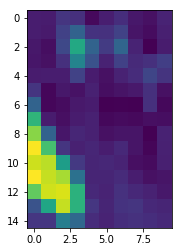

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data_hcp[70:85, 0, 72:82, 0])

In [11]:
fit_args = {'acquisition_scheme': scheme_hcp,
            'data': data_hcp[55:56, :, 68:69],
            'mask': data_hcp[55:56, :, 68:69, 0]>0}
mt_csd_fit = mt_csd_mod.fit(fit_S0_response=False, **fit_args)

Setup CVXPY FOD optimizer in 0.0115189552307 seconds
Using parallel processing with 8 workers.
Fitting of 1 voxels complete in 0.524442911148 seconds.
Average of 0.524442911148 seconds per voxel.


In [12]:
mt_csd_kernel_mod = modeling_framework.MultiCompartmentModel(
    [distribute_models.SD3SphericalHarmonicsDistributed([mck_dist], sh_order=8), TR1_gm, TR1_csf])

In [13]:
mt_csd_fit.fitted_parameters.keys()

['partial_volume_1',
 'partial_volume_0',
 'partial_volume_2',
 'SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
 'sh_coeff',
 'SD1WatsonDistributed_1_SD1Watson_1_odi']

In [14]:
mt_csd_kernel_mod.set_fixed_parameter(
    'SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff',
    mt_csd_fit.fitted_parameters['sh_coeff'])

In [15]:
mt_csd_kernel_mod.parameter_optimization_flags

OrderedDict([('partial_volume_1', True),
             ('partial_volume_0', True),
             ('partial_volume_2', True),
             ('SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi',
              True),
             ('SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0',
              True),
             ('SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
              True),
             ('SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff',
              False)])

In [16]:
mt_csd_kernel_mod.set_initial_guess_parameter(
    'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par',
    mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par'])

In [17]:
mt_csd_kernel_mod.set_initial_guess_parameter(
    'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi',
    mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_SD1Watson_1_odi'])

In [18]:
mt_csd_kernel_mod.set_initial_guess_parameter(
    'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0',
    mt_csd_fit.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0'])

In [19]:
mt_csd_kernel_mod.set_fixed_parameter(
    'partial_volume_0',
    mt_csd_fit.fitted_parameters['partial_volume_0'])

In [20]:
mt_csd_kernel_mod.set_fixed_parameter(
    'partial_volume_1',
    mt_csd_fit.fitted_parameters['partial_volume_1'])

In [21]:
mt_csd_kernel_mod.set_fixed_parameter(
    'partial_volume_2',
    mt_csd_fit.fitted_parameters['partial_volume_2'])

All model parameters set or have initial guess.


In [23]:
fit2 = mt_csd_kernel_mod.fit(use_parallel_processing=False, **fit_args)

All model parameters set or have initial guess.
Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.000308036804199 seconds
Fitting of 1 voxels complete in 2.17640900612 seconds.
Average of 2.17640900612 seconds per voxel.


In [24]:
fit2.fitted_parameters

{'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': array([[[2.26982751e-09]]]),
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_SD1Watson_1_odi': array([[[0.07807019]]]),
 'SD3SphericalHarmonicsDistributed_1_SD1WatsonDistributed_1_partial_volume_0': array([[[0.74885773]]]),
 'SD3SphericalHarmonicsDistributed_1_SD3SphericalHarmonics_1_sh_coeff': array([[[[ 0.27625625, -0.05346016,  0.01866799,  0.33776325,
            0.16801129,  0.12673054, -0.05890545, -0.02915259,
           -0.03118315,  0.05812869,  0.22022139,  0.11112159,
            0.13032324,  0.05466252,  0.04587019, -0.03207914,
           -0.02155538, -0.02644343, -0.00658504, -0.0151373 ,
            0.05181764,  0.09468574,  0.04952322,  0.08703624,
            0.03611304,  0.03654308,  0.0105034 ,  0.00418114,
           -0.01048082, -0.00510104, -0.01306968, -0.00716792,
           -0.01355595,  0.00225081, -0.0020902 ,  0.02195681,
            0.02617016,  0.01332083,  0.

In [25]:
mt_csd_fit.fitted_parameters

{'SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par': array([[[3.0245025e-09]]]),
 'SD1WatsonDistributed_1_SD1Watson_1_odi': array([[[0.15979274]]]),
 'SD1WatsonDistributed_1_partial_volume_0': array([[[0.94384072]]]),
 'partial_volume_0': array([[[0.97930291]]]),
 'partial_volume_1': array([[[-2.94635468e-06]]]),
 'partial_volume_2': array([[[0.02070003]]]),
 'sh_coeff': array([[[[ 0.27625625, -0.05346016,  0.01866799,  0.33776325,
            0.16801129,  0.12673054, -0.05890545, -0.02915259,
           -0.03118315,  0.05812869,  0.22022139,  0.11112159,
            0.13032324,  0.05466252,  0.04587019, -0.03207914,
           -0.02155538, -0.02644343, -0.00658504, -0.0151373 ,
            0.05181764,  0.09468574,  0.04952322,  0.08703624,
            0.03611304,  0.03654308,  0.0105034 ,  0.00418114,
           -0.01048082, -0.00510104, -0.01306968, -0.00716792,
           -0.01355595,  0.00225081, -0.0020902 ,  0.02195681,
            0.02617016,  0.01332083,  0.02827964,  0.01134677,

In [29]:
mt_csd_fit.mean_squared_error(data_hcp[55:56, :, 68:69])

array([[[0.00390161]]])

In [30]:
fit2.mean_squared_error(data_hcp[55:56, :, 68:69])

array([[[0.00328034]]])

Now that the fractions are fitted and there are 3, we can also visualize them as an RGB image. Notice that the WM/GM/CSF areas are reasonably nicely segmented by the estimation itself.

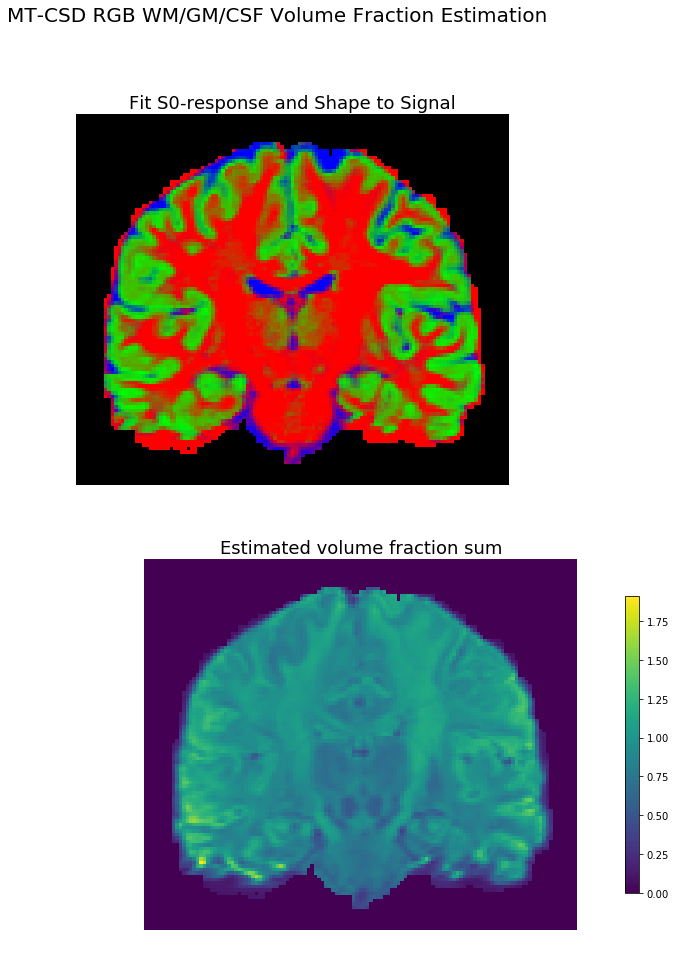

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
txts = ['Fit S0-response and Shape to Signal', 'Fit Only Shape to Signal Attenuation']
vfs_all = []

fig, axs = plt.subplots(2, 1, figsize=[17, 15])
fig.suptitle('MT-CSD RGB WM/GM/CSF Volume Fraction Estimation', fontsize=20)
for i, fit in enumerate([mt_csd_fit]):
    vfs = []
    names = ['partial_volume_0', 'partial_volume_1', 'partial_volume_2']
    for name in names:
        vfs.append(fit.fitted_parameters[name])
    vfs = np.transpose(np.array(vfs), (3, 2, 1, 0))
    vfs_all.append(vfs)
    vfs_sum = np.sum(vfs, axis=-1)
    vfs[vfs_sum > 0] = vfs[vfs_sum > 0] / vfs_sum[vfs_sum > 0][..., None]
    vfs_im = np.squeeze(np.clip(vfs, 0, 1))

    axs[i].imshow(vfs_im[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[i].axis('off');
    axs[i].set_title(txts[i], fontsize=18)
    
    im = axs[i + 1].imshow(np.squeeze(vfs_sum)[15:-23, 10:-10], origin=True, interpolation='nearest')
    axs[i + 1].axis('off');
    axs[i + 1].set_title('Estimated volume fraction sum', fontsize=18)
    fig.colorbar(im, ax=axs[i + 1], shrink=0.8)

## References
- Tournier, J-Donald, Fernando Calamante, and Alan Connelly. "Robust determination of the fibre orientation distribution in diffusion MRI: non-negativity constrained super-resolved spherical deconvolution." Neuroimage 35.4 (2007): 1459-1472.
- Dhollander, T.; Raffelt, D. & Connelly, A. Unsupervised 3-tissue response function estimation from single-shell or multi-shell diffusion MR data without a co-registered T1 image. ISMRM Workshop on Breaking the Barriers of Diffusion MRI, 2016, 5
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.